In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from astropy.stats.circstats import circmean
from functools import reduce
import datetime
import pickle
import time
import plotly.express as px
import numpy as np
import sqlite3

pd.set_option("display.precision", 2)
plt.rcParams.update({'font.size': 20, 'figure.figsize': (8, 4)})

%matplotlib inline
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

import seaborn as sns
sns.set()

import warnings
warnings.filterwarnings('ignore')

In [2]:
connector = sqlite3.connect("../Extras/graphs_data.db")
cursor = connector.cursor()

### Auxiliary functions implementation

In [3]:
def build_average_per_minute_arr_from_database_rows(rows):
    """
    input: rows from a database
    output: average heartrate per minute list
    
    The function retrieves rows from a database,
    extracts heart rate dictionary from each row (with keys representing time in seconds and values representing heart rate values).
    It then constructs and returns a list in which each index corresponds to a minute throughout the day,
    containing the average heart rate for that minute.
    """
    lst = [[] for _ in range(24*60+1)]
    for row in rows:
    # dict  = (keys is the time in seconds during day, value is the heartrate value)
        heartrate_samples_dict = pickle.loads(row[3])
        for time_key in heartrate_samples_dict:
            lst[int(time_key*60)].append(heartrate_samples_dict[time_key])
    
    return lst

def build_averages_per_query_lst(sql_query_lst):
    """
    input: a list containing sql queries
    output: list of lists, each list contains the average heartrate value per minute corresponds the sql query data.
    """
    retlist = list()
    for query in sql_query_lst:
        cursor.execute(query)
        rows = cursor.fetchall()
        values_per_minute_lst = build_average_per_minute_arr_from_database_rows(rows)
        average_per_minute_lst = [sum(x)/len(x) if len(x)!=0 else 0 for x in values_per_minute_lst]
        retlist.append(average_per_minute_lst)
    
    return retlist

def print_graph_from_catagory_sqlquery_list(catagory_list, query_list, colors_key_list, *exam_times):
    """
    input: - catagory strings list (e.g. "morning type students")
           - sql query list (each query descripe that data corresponds to catagory in catagories list)
           - colors list
           - exam hour incase the some of the lineplots descripe heartrate during exam day
           - zero or more exam start times
    
    the function prints graph based on the received data.
    """
    assert len(catagory_list) == len(query_list) , "catagory and averages lists len should be equal"
    averages_list = build_averages_per_query_lst(query_list)
    
    # Create a list of indices
    indices = list(range(len(averages_list[0])))

    # Plot the values
    plt.figure(figsize=(10,6))

    for i in range(len(catagory_list)):
        plt.plot(indices,averages_list[i], label=catagory_list[i], color=colors_key_list[i])
    
    # Set the x-axis to represent hours
    plt.xticks([i*60 for i in range(25)], [str(i) for i in range(25)])
    
    # set vertical line that descripes exam start time
    for time in exam_times:
        plt.axvline(x= (time * 60), color='grey', linestyle='--', label='Exam start time')


    # Add labels, title, and legend
    plt.xlabel('Minute')
    plt.ylabel('Average-Heartrate')
    plt.title('Heartrate average value per minute during day')
    plt.legend()

    # Show the grid
    plt.grid(True)

    # Show the graph
    plt.tight_layout()
    plt.show()


### printing each group (morning/evening) average heartrate on 2023-02-05

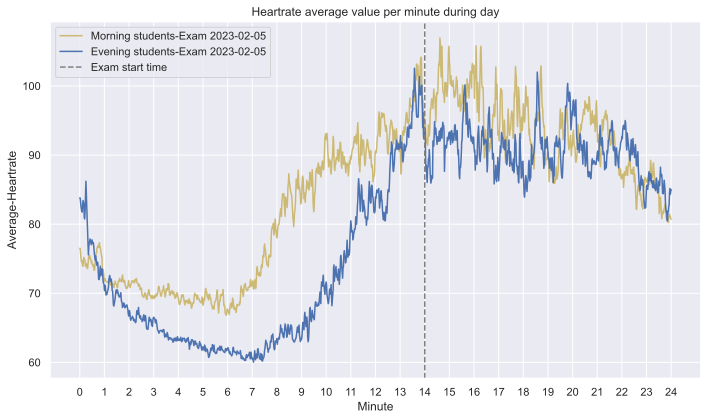

In [4]:
EXAM_TIME = 14

catagory_list = ['Morning students-Exam 2023-02-05', 'Evening students-Exam 2023-02-05']
query_list = ["SELECT * FROM heartrate_graphs_data WHERE id>=200 and id <300 and date='2023-02-05'",
              "SELECT * FROM heartrate_graphs_data WHERE id>=100 and id <200 and date='2023-02-05'"]
color_list = ['y','b']

print_graph_from_catagory_sqlquery_list(catagory_list, query_list, color_list, EXAM_TIME)

### printing each group (morning/evening) average heartrate - the whole research period

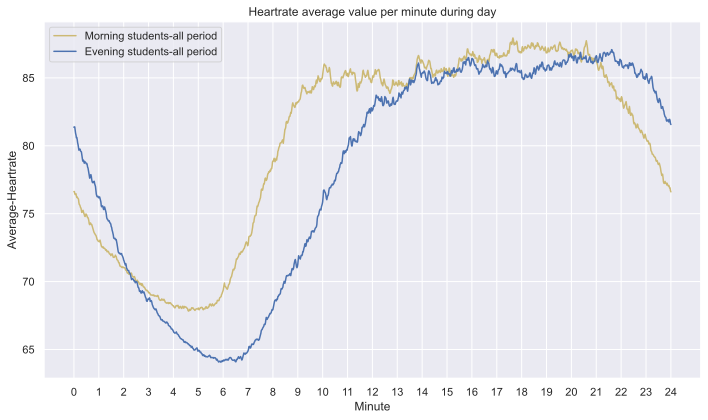

In [5]:
catagory_list = ['Morning students-all period', 'Evening students-all period']
query_list = ["SELECT * FROM heartrate_graphs_data WHERE id>=200 and id <300",
              "SELECT * FROM heartrate_graphs_data WHERE id>=100 and id <200"]
color_list = ['y','b']

print_graph_from_catagory_sqlquery_list(catagory_list, query_list, color_list)